In [1]:
# Import 需要的套件
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# 設定 data_path
dir_data = './data/'
f_app_train = os.path.join(dir_data, 'application_train.csv')
f_app_test = os.path.join(dir_data, 'application_test.csv')

app_train = pd.read_csv(f_app_train)
app_test = pd.read_csv(f_app_test)

from sklearn.preprocessing import LabelEncoder

# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(app_train[col])
            # Transform both training and testing data
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

# Create an anomalous flag column
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
# also apply to testing dataset
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

# absolute the value of DAYS_BIRTH
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_test['DAYS_BIRTH'] = abs(app_test['DAYS_BIRTH'])

### 相關係數
一樣，pandas 很貼心地讓我們可以非常容易計算相關係數

In [3]:
app_corr = app_train.corr()['TARGET']
app_corr

SK_ID_CURR                                 -0.002108
TARGET                                      1.000000
NAME_CONTRACT_TYPE                         -0.030896
FLAG_OWN_CAR                               -0.021851
FLAG_OWN_REALTY                            -0.006148
CNT_CHILDREN                                0.019187
AMT_INCOME_TOTAL                           -0.003982
AMT_CREDIT                                 -0.030369
AMT_ANNUITY                                -0.012817
AMT_GOODS_PRICE                            -0.039645
REGION_POPULATION_RELATIVE                 -0.037227
DAYS_BIRTH                                 -0.078239
DAYS_EMPLOYED                               0.074958
DAYS_REGISTRATION                           0.041975
DAYS_ID_PUBLISH                             0.051457
OWN_CAR_AGE                                 0.037612
FLAG_MOBIL                                  0.000534
FLAG_EMP_PHONE                              0.045982
FLAG_WORK_PHONE                             0.

## 練習時間
列出目標 (TARGET) 與所有欄位之間相關係數，數值最大以及最小各 15 個

通過相關係數的結果觀察有興趣的欄位與 TARGET 或其他欄位的相關係數，並嘗試找出有趣的訊息
- 最好的方式當然是畫圖，舉例來說，我們知道  EXT_SOURCE_3 這個欄位和 TARGET 之間的相關係數是 -0.178919 (在已經這個資料集已經是最負的了！)，那我們可以 EXT_SOURCE_3  為 x 軸， TARGET 為 y 軸，把資料給畫出來

In [4]:
#數值最大15個
print(app_corr.sort_values(ascending=False).head(15))

#數值最小15個
print(app_corr.sort_values().head(15))

TARGET                                               1.000000
DAYS_EMPLOYED                                        0.074958
REGION_RATING_CLIENT_W_CITY                          0.060893
REGION_RATING_CLIENT                                 0.058899
NAME_INCOME_TYPE_Working                             0.057481
DAYS_LAST_PHONE_CHANGE                               0.055218
CODE_GENDER_M                                        0.054713
DAYS_ID_PUBLISH                                      0.051457
REG_CITY_NOT_WORK_CITY                               0.050994
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
FLAG_EMP_PHONE                                       0.045982
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_DOCUMENT_3                                      0.044346
OCCUPATION_TYPE_Laborers                             0.043019
DAYS_REGISTRATION                                    0.041975
Name: TARGET, dtype: float64
EXT_SOURCE_3                           -0

數值資料 VS. 類別資料

count    252137.000000
mean          6.531971
std           6.406466
min          -0.000000
25%           2.101370
50%           4.515068
75%           8.698630
max          49.073973
Name: DAYS_EMPLOYED_year, dtype: float64


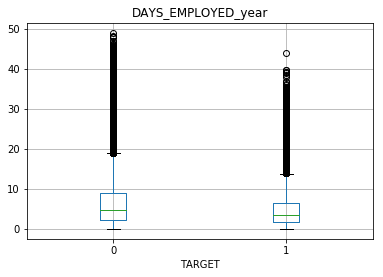

In [5]:
app_train["DAYS_EMPLOYED_year"] = app_train['DAYS_EMPLOYED'] / (-365)
print(app_train["DAYS_EMPLOYED_year"].describe())
app_train.boxplot(column = 'DAYS_EMPLOYED_year', by = 'TARGET')
plt.suptitle(" ")

類別資料 VS. 類別資料

In [6]:
print("TARGET = 0")
t0 = app_train[app_train['TARGET'] == 0].groupby("REGION_RATING_CLIENT_W_CITY").size().sort_index()
print(t0)

print("TARGET = 1")
t1 = app_train[app_train['TARGET'] == 1].groupby("REGION_RATING_CLIENT_W_CITY").size().sort_index()
print(t1)

TARGET = 0
REGION_RATING_CLIENT_W_CITY
1     32513
2    211314
3     38859
dtype: int64
TARGET = 1
REGION_RATING_CLIENT_W_CITY
1     1654
2    18170
3     5001
dtype: int64


In [7]:
df_t0 = pd.DataFrame(t0).reset_index().rename(index=str, columns={"REGION_RATING_CLIENT_W_CITY": "class", 0 : "freq"})
df_t1 = pd.DataFrame(t1).reset_index().rename(index=str, columns={"REGION_RATING_CLIENT_W_CITY": "class", 0 : "freq"})
x_pos0 = np.arange(1, 4, 1)
x_pos1 = np.arange(5, 8, 1)

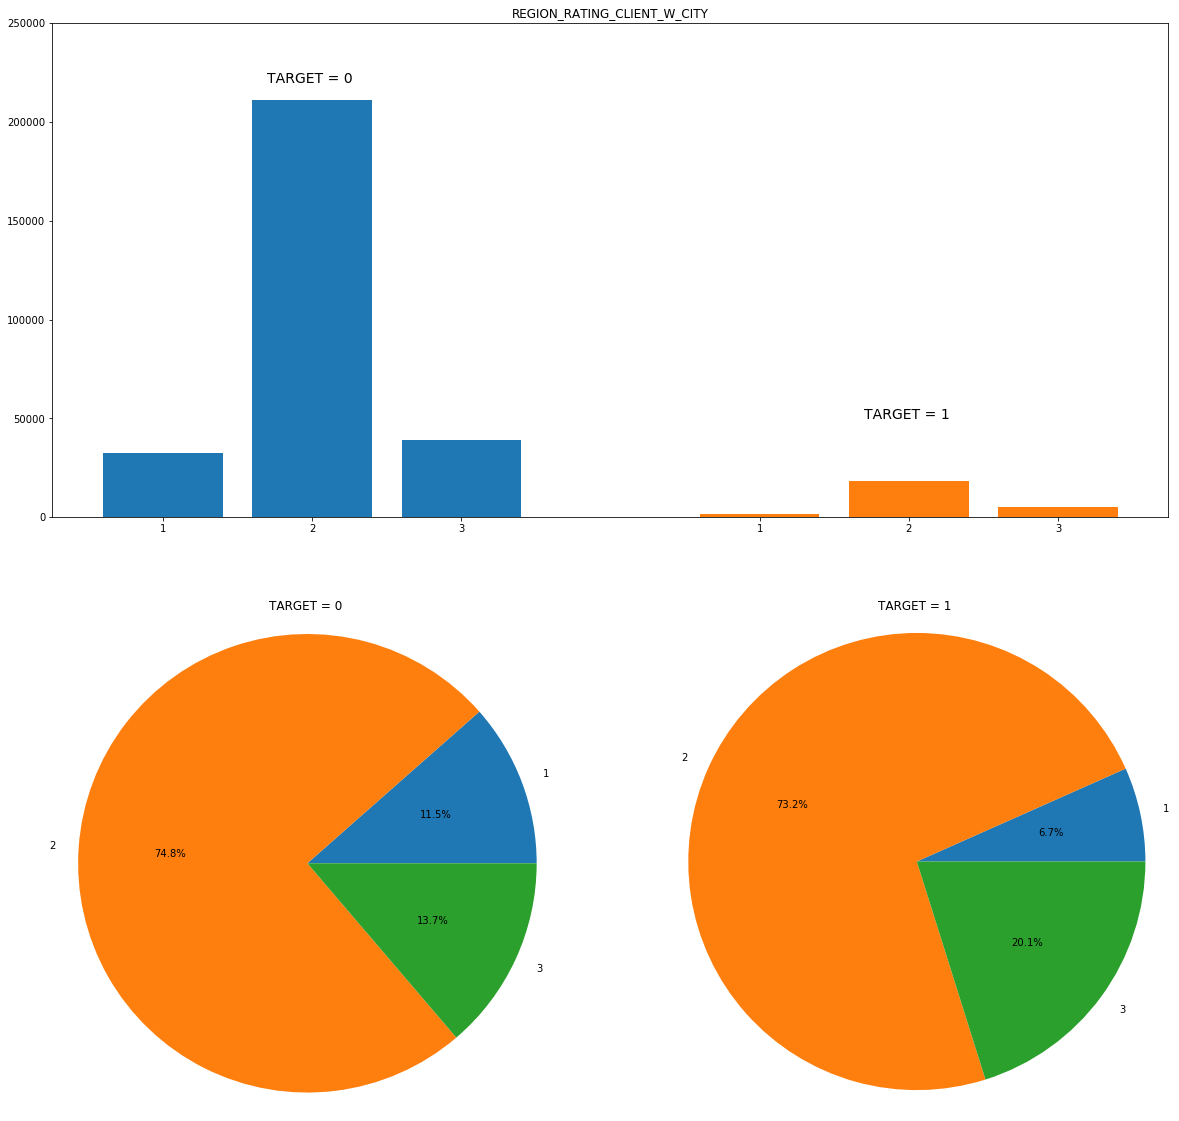

In [8]:
plt.figure(figsize=(20, 20))

plt.subplot(2, 1, 1)
plt.bar(x_pos0, df_t0["freq"])
plt.bar(x_pos1, df_t1["freq"])
plt.xticks(np.append(x_pos0, x_pos1), pd.concat([df_t0,df_t1])["class"])
plt.title("REGION_RATING_CLIENT_W_CITY")
plt.ylim((0, 250000))
plt.text(1.7, 220000, "TARGET = 0", size=14)
plt.text(5.7, 50000, "TARGET = 1", size=14)

plt.subplot(2, 2, 3)
plt.pie(df_t0["freq"], labels = df_t0["class"], autopct = "%1.1f%%")
plt.axis("equal")
plt.title("TARGET = 0")

plt.subplot(2, 2, 4)
plt.pie(df_t1["freq"], labels = df_t1["class"], autopct = "%1.1f%%")
plt.axis("equal")
plt.title("TARGET = 1")
plt.show()